In [1]:
# Clean up old CSV files and re-run
#!rm actions_*.csv outcomes_*.csv; time python battle.py

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as pn
rnd = np.random.default_rng()

In [3]:
def load(p):
    df = pd.read_csv(p)
    df['csv'] = str(p)
    return df

df = pd.concat([load(x) for x in Path().glob("outcomes_*.csv") if x.stat().st_size > 1000], ignore_index=True)
df.team = np.array(['PCs', 'monsters'])[df.team]
df.head()

,epoch,encounter,num_rounds,actor,team,team_win,max_hp,final_hp,csv
0,0,0,4,Wizard 2,PCs,True,14,14,outcomes_11540.csv
1,0,0,4,Goblin 4,monsters,False,9,0,outcomes_11540.csv
2,0,0,4,Goblin 2,monsters,False,11,0,outcomes_11540.csv
3,0,0,4,Fighter 2,PCs,True,20,20,outcomes_11540.csv
4,0,0,4,Goblin 1,monsters,False,10,0,outcomes_11540.csv


How injured does each actor end up?

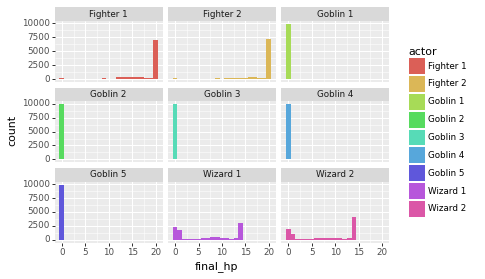

<ggplot: (112430551938)>

In [4]:
x = df[df.epoch > df.epoch.max()-10].copy() # last 10 epochs
#x = x.groupby(['epoch', 'encounter', 'csv', 'team']).sum()
#x['frac_hp'] = x.final_hp / x.max_hp
x = x.reset_index()
#pn.qplot('max_hp', data=x, geom='histogram', fill='actor', binwidth=1) + pn.facet_wrap('actor')
pn.qplot('final_hp', data=x, geom='histogram', fill='actor', binwidth=1) + pn.facet_wrap('actor')

In [5]:
def load(p):
    df = pd.read_csv(p)
    df['csv'] = str(p)
    return df

df = pd.concat([load(x) for x in Path().glob("actions_*.csv") if x.stat().st_size > 1000], ignore_index=True)
df.head()

,epoch,encounter,round,actor,action,target,t_dodging,t_weakest,raw_hp,obs_hp,csv
0,0,0,0,Wizard 2,Magic Missle,Goblin 4,False,False,-12,-9,actions_11540.csv
1,0,0,0,Goblin 2,Dodge,Goblin 2,False,False,0,0,actions_11540.csv
2,0,0,0,Fighter 2,long sword,Goblin 2,True,False,0,0,actions_11540.csv
3,0,0,0,Goblin 1,scimitar,Wizard 2,False,True,0,0,actions_11540.csv
4,0,0,0,Wizard 1,Magic Missle,Goblin 3,False,False,-10,-7,actions_11540.csv


How long do battles typically last, as a function of epoch?

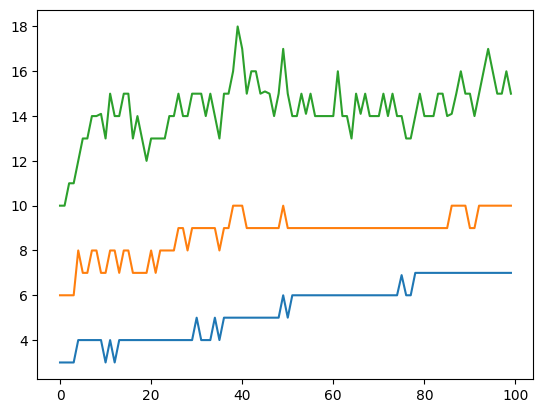

In [6]:
x = df.groupby(['epoch', 'encounter', 'csv'])['round'].max().groupby('epoch')
y = x.quantile(0.1)+1; plt.plot(y.index, y)
y = x.quantile(0.5)+1; plt.plot(y.index, y)
y = x.quantile(0.9)+1; plt.plot(y.index, y)

How often do we choose each possible action, as a function of time?

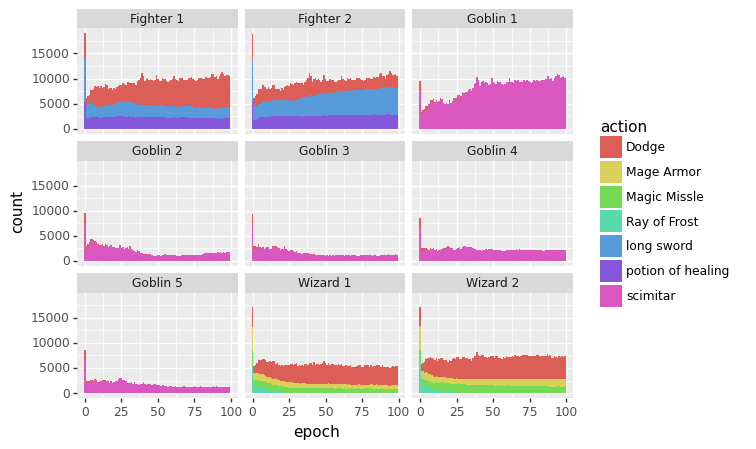

<ggplot: (112430554796)>

In [7]:
pn.qplot('epoch', data=df, fill='action', geom='histogram', binwidth=1) + pn.facet_wrap('actor')

Close-up from final epoch:

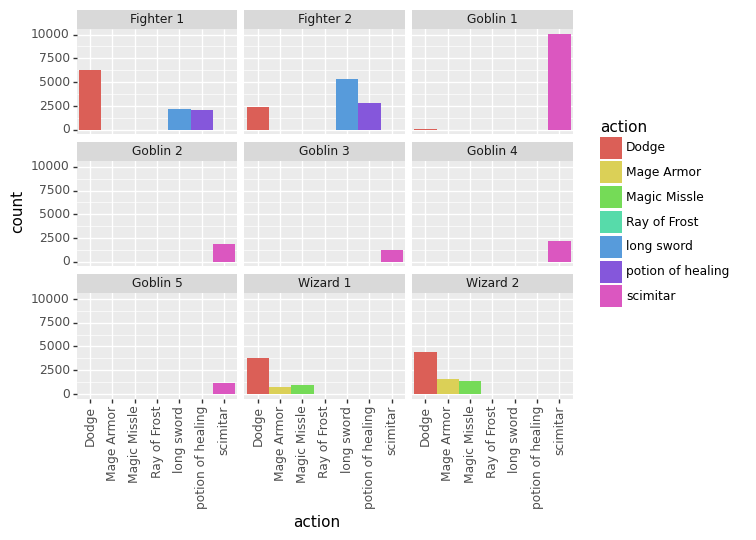

<ggplot: (112439894122)>

In [8]:
x = df[df.epoch == df.epoch.max()]
pn.qplot('action', data=x, fill='action', geom='histogram', binwidth=1) + pn.facet_wrap('actor') + pn.theme(axis_text_x=pn.element_text(rotation=90))

Do we use our healing potions more effectively as time goes on?

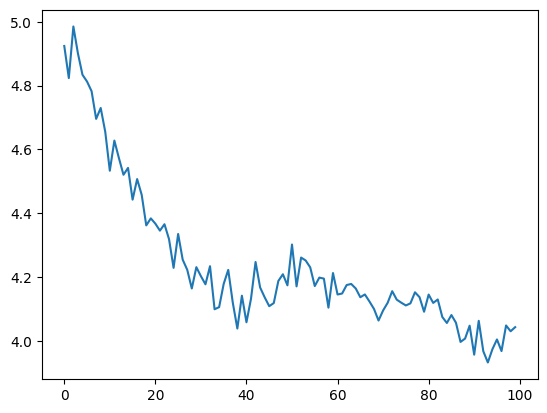

In [9]:
# Mean effect?
x = df.query('raw_hp > 0').groupby('epoch')['obs_hp'].mean()
plt.plot(x.index, x)
# How often do we use it when we're uninjured?  Not often, it's forbidden.
# x = df.query('raw_hp > 0 and obs_hp == 0').groupby('epoch').count()
# plt.plot(x.index, x.obs_hp)

Which enemy does each character attack?

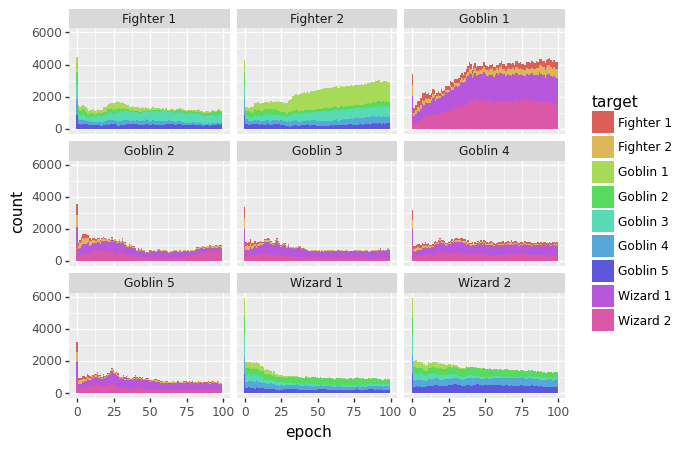

<ggplot: (112439592644)>

In [10]:
x = df.query('raw_hp < 0')
pn.qplot('epoch', data=x, fill='target', geom='histogram', binwidth=1) + pn.facet_wrap('actor')

How often do we target the weakest enemy?

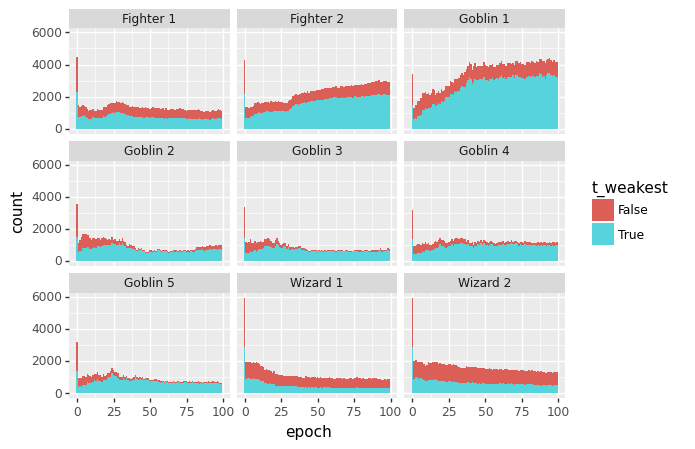

<ggplot: (112442495588)>

In [11]:
x = df.query('raw_hp < 0')
pn.qplot('epoch', data=x, fill='t_weakest', geom='histogram', binwidth=1) + pn.facet_wrap('actor')

How often do we switch targets within an encounter?

In [12]:
x = df.query('actor == "Hero" and action == "long sword"').copy()
#x['round2'] = x.groupby(['epoch', 'encounter', 'csv'])['round'].rank().astype('int')
# Convert target to numerical values
x['tgt'] = pd.Categorical(x.target).codes
# Detect changes in target
x['change_tgt'] = (x.groupby(['epoch', 'encounter', 'csv'])['tgt'].diff() != 0)
x.head()
#dir(x.tgt.cat)

,epoch,encounter,round,actor,action,target,t_dodging,t_weakest,raw_hp,obs_hp,csv,tgt,change_tgt


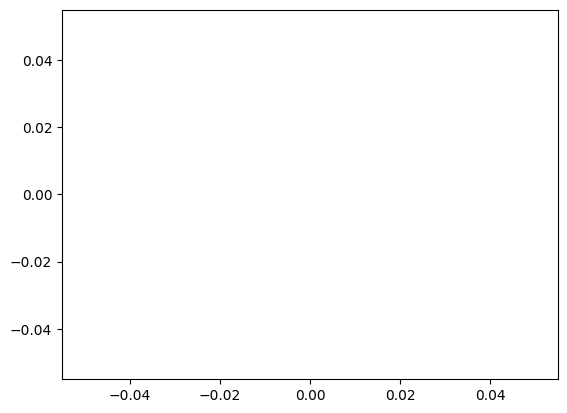

In [13]:
# Minimum is 2 (for a win):  initial attack, and switch to second target
y = x.groupby('epoch')['change_tgt'].sum() / 1000
plt.plot(y.index, y)

Which enemy do we attack first?

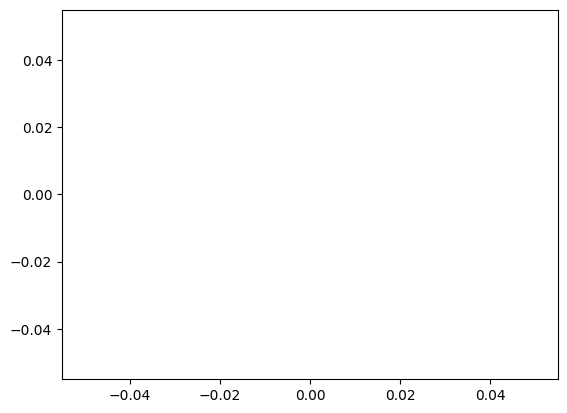

In [14]:
y = x.query('round == 0').groupby('epoch')['tgt'].mean()
plt.plot(y.index, y)

Look at a random encounter from the final epoch of training...

In [15]:
x = df[(df.epoch == df.epoch.max()) & (df.csv == rnd.choice(df.csv))]
x = x[x.encounter == rnd.choice(x.encounter)]
x

,epoch,encounter,round,actor,action,target,t_dodging,t_weakest,raw_hp,obs_hp,csv
4744527,99,793,0,Goblin 5,scimitar,Wizard 1,False,True,-7,-7,actions_11540.csv
4744528,99,793,0,Goblin 4,scimitar,Wizard 1,False,True,-8,-7,actions_11540.csv
4744529,99,793,0,Goblin 3,scimitar,Wizard 2,False,True,0,0,actions_11540.csv
4744530,99,793,0,Fighter 1,long sword,Goblin 3,False,False,-5,-5,actions_11540.csv
4744531,99,793,0,Fighter 2,long sword,Goblin 3,False,True,0,0,actions_11540.csv
4744532,99,793,0,Wizard 2,Magic Missle,Goblin 2,False,False,-11,-10,actions_11540.csv
4744533,99,793,0,Goblin 1,scimitar,Wizard 2,False,True,-6,-6,actions_11540.csv
4744534,99,793,1,Goblin 5,scimitar,Wizard 2,False,True,-3,-3,actions_11540.csv
4744535,99,793,1,Goblin 4,scimitar,Wizard 2,False,True,-3,-3,actions_11540.csv
4744536,99,793,1,Goblin 3,scimitar,Wizard 2,False,True,-3,-2,actions_11540.csv


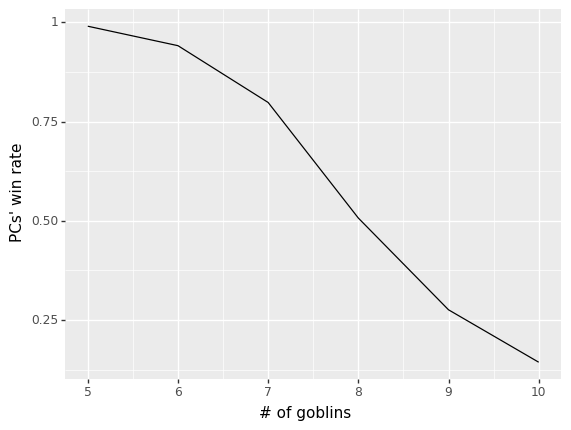

<ggplot: (112441548761)>

In [16]:
# Wins and losses at 2nd level:  2 fighters and 2 wizards vs. X goblins
pc_win_rate = {
    5: 990/1000, # 1:30
    6: 941/1000, # 1:45
    7: 798/1000, # 2:10
    8: 507/1000,
    9: 276/1000, # 3:20
    10: 144/1000, # 4 hours to train
}
#plt.plot(pc_win_rate.keys(), pc_win_rate.values())
pn.qplot(list(pc_win_rate.keys()), list(pc_win_rate.values()), geom='line', xlab='# of goblins', ylab="PCs' win rate")